# Semi-supervised learning with the Cora dataset

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid


dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

## Loopy belief propagation

In [2]:
import networkx as nx
import os
os.chdir('..')
from factorgraph import FactorGraph, VariableNode, FactorNode, Potential
from algorithms import LoopyBP

# Set up complete Cora graph
G = nx.Graph()
nodes = np.arange(data.x.shape[0])
train_nodes = np.where(data.train_mask)[0]
val_nodes = np.where(data.val_mask)[0]
test_nodes = np.where(data.test_mask)[0]
G.add_nodes_from(nodes, node_type="")
G.add_nodes_from(train_nodes, node_type="train") # Label training set
G.add_nodes_from(val_nodes, node_type="val") # Label validation set
G.add_nodes_from(test_nodes, node_type="test") # Label test set

# edges = [tuple([int(a), int(b)]) for a, b in zip(*data.edge_index)]
edges = set([frozenset([int(a), int(b)]) for a, b in zip(*data.edge_index)])
G.add_edges_from(edges)

### Construct factor graph

In [3]:
# Add pairwise potentials connecting two test nodes
factor_graph_edges = []
pairwise_factors = []
nodewise_factors = []
observed_nodes = []
for edge in edges:
    i, j = list(edge)
    v_i, v_j = G.nodes[i], G.nodes[j] # Get node pair corresponding to edge
    if (v_i['node_type'] == "test") and (v_j['node_type'] == "test"):
        pairwise_factors.append(edge)
        factor_graph_edges.append((i, edge))
        factor_graph_edges.append((j, edge))
    elif (v_i['node_type'] == "train") and (v_j['node_type'] == "test"):
        observed_nodes.append(i)
        nodewise_factors.append(edge)
        factor_graph_edges.append((j, edge))
    elif (v_i['node_type'] == "test") and (v_j['node_type'] == "train"):
        observed_nodes.append(j)
        nodewise_factors.append(edge)
        factor_graph_edges.append((i, edge))

variable_nodes = test_nodes
factor_nodes = pairwise_factors + nodewise_factors

# Set up bipartite graph corresponding to the factor graph
B = nx.Graph()
B.add_nodes_from(variable_nodes, node_type="variable")
B.add_nodes_from(factor_nodes, node_type="factor")
B.add_edges_from(factor_graph_edges)

# Set up variable nodes
num_states = 7
variable_vals = [VariableNode(num_states) for _ in variable_nodes]
variables = dict(zip(variable_nodes, variable_vals))

# Set up factor nodes
Psi = (0.1/(num_states-1)) * np.ones((num_states, num_states))
for i in range(num_states):
    Psi[i,i] = 0.9
    
factornodes_pairwise = [FactorNode( Potential(Psi,list(B.neighbors(factorID))) ) for factorID in pairwise_factors]
factornodes_nodewise = []
for obs_node, factorID in zip(observed_nodes, nodewise_factors):
    c = int(data.y[obs_node]) # Class label of obs_node, which is a value between 1 and 7.
    psi_ = Psi[c] # Take nodewise potential to be the c-th row of Psi, which is a 1D vector.
    factornode = FactorNode( Potential(psi_,list(B.neighbors(factorID))) )
    factornodes_nodewise.append(factornode)

factor_vals = factornodes_pairwise + factornodes_nodewise
factors = dict(zip(factor_nodes, factor_vals))

# Set up factor graph
f = FactorGraph(B, variables, factors)


Final accuracy: 48.8%


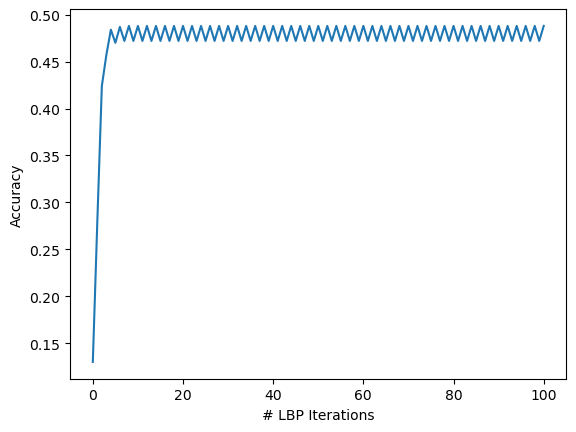

In [5]:
def compute_accuracy(factorgraph):
    score = 0
    for node, variable in factorgraph.variables.items():
        label = int(data.y[node]) # Ground truth
        pred = np.argmax(variable.state) # Predict using the mode
        if label == pred:
            score += 1

    accuracy = score / len(factorgraph.variables)
    return accuracy

num_iter = 100
accuracy_list = []
f.reset()
acc = compute_accuracy(f)
accuracy_list.append(acc)
for iter in range(num_iter):
    LoopyBP(f)
    acc = compute_accuracy(f)
    accuracy_list.append(acc)

plt.plot(accuracy_list)
plt.xlabel('# LBP Iterations')
plt.ylabel('Accuracy')

print(f'Final accuracy: {accuracy_list[-1]*100:>0.1f}%')

## Multilayer Perceptron

In [6]:
# Define simple MLP model
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(1433, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 7)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
        self.X = X
        self.y = y

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y


In [7]:
# Split data for training/validation/testing
train_dataset = [data.x[train_nodes], data.y[train_nodes]]
train_dataset = Dataset(*train_dataset)

val_dataset = [data.x[val_nodes], data.y[val_nodes]]
val_dataset = Dataset(*val_dataset)

test_dataset = [data.x[test_nodes], data.y[test_nodes]]
test_dataset = Dataset(*test_dataset)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [8]:
model = MLP()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                 milestones=[20, 30, 50, 100], # List of epoch indices
                                                 gamma=0.5)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return val_loss

In [9]:
epochs = 200
val_loss_curve = []
train_loss_curve = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    train_loss = validate(train_dataloader, model, loss_fn)
    val_loss = validate(val_dataloader, model, loss_fn)
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 1.943475  [    0/  140]
Test Error: 
 Accuracy: 17.9%, Avg loss: 1.938161 

Test Error: 
 Accuracy: 8.8%, Avg loss: 1.951704 

Epoch 2
-------------------------------
loss: 1.950783  [    0/  140]
Test Error: 
 Accuracy: 18.6%, Avg loss: 1.930326 

Test Error: 
 Accuracy: 7.2%, Avg loss: 1.954669 

Epoch 3
-------------------------------
loss: 1.955062  [    0/  140]
Test Error: 
 Accuracy: 20.7%, Avg loss: 1.922567 

Test Error: 
 Accuracy: 7.2%, Avg loss: 1.956290 

Epoch 4
-------------------------------
loss: 1.956775  [    0/  140]
Test Error: 
 Accuracy: 28.6%, Avg loss: 1.914130 

Test Error: 
 Accuracy: 8.0%, Avg loss: 1.956940 

Epoch 5
-------------------------------
loss: 1.956524  [    0/  140]
Test Error: 
 Accuracy: 36.4%, Avg loss: 1.904270 

Test Error: 
 Accuracy: 8.8%, Avg loss: 1.956722 

Epoch 6
-------------------------------
loss: 1.954518  [    0/  140]
Test Error: 
 Accuracy: 41.4%, Avg loss: 1.892109 

Test Error: 


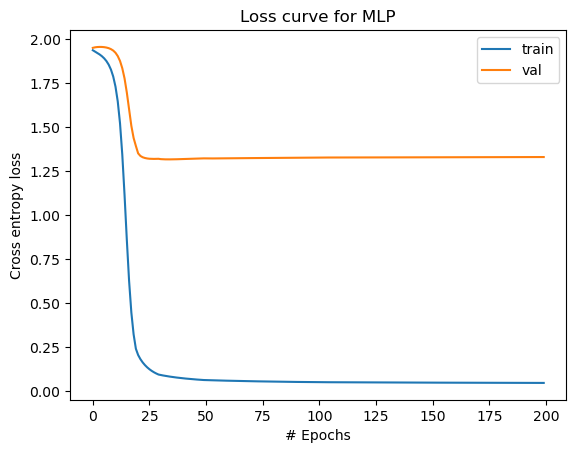

In [10]:
plt.plot(train_loss_curve, label='train')
plt.plot(val_loss_curve, label='val')
plt.xlabel("# Epochs")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for MLP")
plt.legend()

In [11]:
test_loss = validate(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 57.1%, Avg loss: 1.265451 



## Graph Convolutional Network

In [12]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [13]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

epochs = 200
model.train()
val_loss_curve = []
train_loss_curve = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    train_loss_curve.append(float(train_loss))
    train_loss.backward()
    optimizer.step()
    
    # Validate
    model.eval()
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    val_loss_curve.append(float(val_loss))
    pred = model(data).argmax(dim=1)
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    acc = int(correct) / int(data.val_mask.sum())
    print(f"Epoch {epoch}: Accuracy: {(100*acc):>0.1f}%, Avg loss: {val_loss:>8f}")


Epoch 0: Accuracy: 36.4%, Avg loss: 1.957369
Epoch 1: Accuracy: 42.8%, Avg loss: 1.908443
Epoch 2: Accuracy: 44.8%, Avg loss: 1.850054
Epoch 3: Accuracy: 49.2%, Avg loss: 1.780481
Epoch 4: Accuracy: 52.8%, Avg loss: 1.710304
Epoch 5: Accuracy: 57.0%, Avg loss: 1.639464
Epoch 6: Accuracy: 61.8%, Avg loss: 1.562640
Epoch 7: Accuracy: 66.4%, Avg loss: 1.480529
Epoch 8: Accuracy: 70.4%, Avg loss: 1.396518
Epoch 9: Accuracy: 73.4%, Avg loss: 1.313609
Epoch 10: Accuracy: 75.0%, Avg loss: 1.234081
Epoch 11: Accuracy: 77.0%, Avg loss: 1.159837
Epoch 12: Accuracy: 77.0%, Avg loss: 1.092184
Epoch 13: Accuracy: 77.4%, Avg loss: 1.031657
Epoch 14: Accuracy: 78.2%, Avg loss: 0.978595
Epoch 15: Accuracy: 78.4%, Avg loss: 0.932951
Epoch 16: Accuracy: 78.2%, Avg loss: 0.894720
Epoch 17: Accuracy: 76.8%, Avg loss: 0.863600
Epoch 18: Accuracy: 76.4%, Avg loss: 0.839052
Epoch 19: Accuracy: 76.4%, Avg loss: 0.820307
Epoch 20: Accuracy: 76.0%, Avg loss: 0.806288
Epoch 21: Accuracy: 75.8%, Avg loss: 0.79580

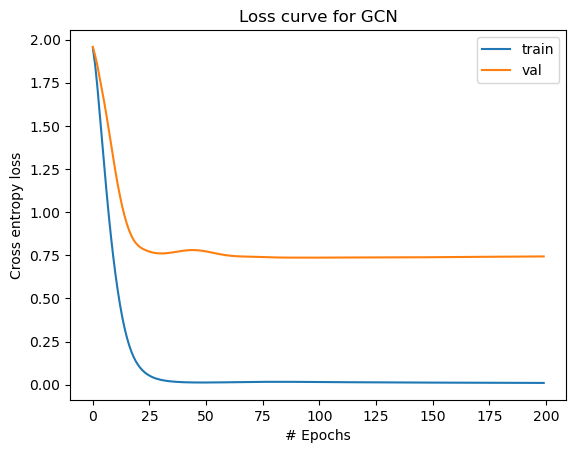

In [14]:
plt.plot(train_loss_curve, label='train')
plt.plot(val_loss_curve, label='val')
plt.xlabel("# Epochs")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for GCN")
plt.legend()

In [15]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Test accuracy: {acc*100:>0.1f}%')

Test accuracy: 81.1%
